## Neuroinformatics Project 1: MRI upscaling


## Imports


In [1]:
import os, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torch.optim as optim
from torch.optim import lr_scheduler


from tempfile import TemporaryDirectory

import torch.backends.cudnn as cudnn

import nibabel as nib
from nilearn import plotting



from extract_slices import (
    # load_nifti,
    slice_to_base64,
    base64_to_slice,
    volume_to_submission_rows,
    create_submission_df
)

# import metric
from metric_pt2 import compute_ms_ssim
# import extract_slices


from tqdm import tqdm 

device = "cpu"
# if torch.backends.mps.is_available():
#     device = "mps"
if torch.cuda.is_available():
    device = "cuda"
    cudnn.benchmark = True
    
print("device:", device)




# Configuration
CONFIG = {
    "SEED": 42,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "BATCH_SIZE": 2,
    "LR": 2e-4,
    "WEIGHT_DECAY": 1e-5,
    "NUM_EPOCHS":100,
    "PATIENCE":20,
    "PATCH_SIZE": (96, 96, 96),
    "PATHS": {
        "TRAIN": "./train/",
        "TEST": "./test/",
        "CHECKPOINT": "./runs/checkpoint_final",
    },
}



# Reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


set_seed(CONFIG["SEED"])
print(f"Running on: {CONFIG['DEVICE']}")

device: cuda
Running on: cuda


### normalize mri


In [2]:
def normalize_mri(tensor):
    # Min-Max Scaling to [0, 1]
    denom = tensor.max() - tensor.min() + 1e-8
    return (tensor - tensor.min()) / denom

In [3]:
def load_nifti(path, normalize=True):
    """
    Load a NIfTI file and return the data array.

    Args:
        path: Path to .nii.gz file

    Returns:
        3D numpy array (x, y, z)
    """
    img = nib.load(path).get_fdata()

    if normalize:
        img = normalize_mri(img)

    return img

In [4]:
def display_nifti(img):
    """
    Display a NIfTI file give fdata().

    Args:
        img: fdata associated with a nifti file
    """

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.imshow(img[img.shape[0] // 2, :, :].T, cmap="gray", origin="lower")
    plt.title("Middle Slice")
    plt.axis("off")

    plt.tight_layout()

    plt.show()

In [5]:
# PROJECT_DIR = "N:/OneDrive - Youngstown State University/3. NYU/25-26/Spring 2026/Neuroinformatics/Projects/Project 1"
PROJECT_DIR = "./"

TRAIN_DIR = os.path.join(PROJECT_DIR, "train/")
TEST_DIR = os.path.join(PROJECT_DIR, "test/")

HF_TRAIN = os.path.join(TRAIN_DIR, "high_field/")
LF_TRAIN = os.path.join(TRAIN_DIR, "low_field/")

LF_TEST = os.path.join(TEST_DIR, "low_field/")

TRAIN_GROUND_TRUTH_PATH = os.path.join(PROJECT_DIR, "train.csv")

# Synthetic dataset

SYNTHETIC_HF = os.path.join(PROJECT_DIR, "simulated_data/HR/")
SYNTHETIC_LF = os.path.join(PROJECT_DIR, "simulated_data/LR/")


print(HF_TRAIN)
print(SYNTHETIC_HF)

./train/high_field/
./simulated_data/HR/


In [6]:
ground_truth_df = pd.read_csv(TRAIN_GROUND_TRUTH_PATH)

ground_truth_df.head()

,row_id,ground_truth
0,sample_001_slice_000,UEsDBC0AAAAIAAAAIQCRRkEa//////////8JABQAc2xpY2...
1,sample_001_slice_001,UEsDBC0AAAAIAAAAIQCGlxaq//////////8JABQAc2xpY2...
2,sample_001_slice_002,UEsDBC0AAAAIAAAAIQBbPb4m//////////8JABQAc2xpY2...
3,sample_001_slice_003,UEsDBC0AAAAIAAAAIQCpeNev//////////8JABQAc2xpY2...
4,sample_001_slice_004,UEsDBC0AAAAIAAAAIQBOZi+L//////////8JABQAc2xpY2...


## Trial image loading


### Project Data


In [7]:
def load_nifti_pair(sample_id):

    LF_sample_path = os.path.join(LF_TRAIN, f"{sample_id}_lowfield.nii")
    HF_sample_path = os.path.join(HF_TRAIN, f"{sample_id}_highfield.nii")

    return {"lowfield": LF_sample_path, "highfield": HF_sample_path}

In [8]:
sample_id = "sample_001"

sample_path_pair = load_nifti_pair(sample_id)

for sample_path in sample_path_pair.items():
    volume = load_nifti(sample_path[1], normalize=True)

    volume = normalize_mri(volume)

    print(volume)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0.     

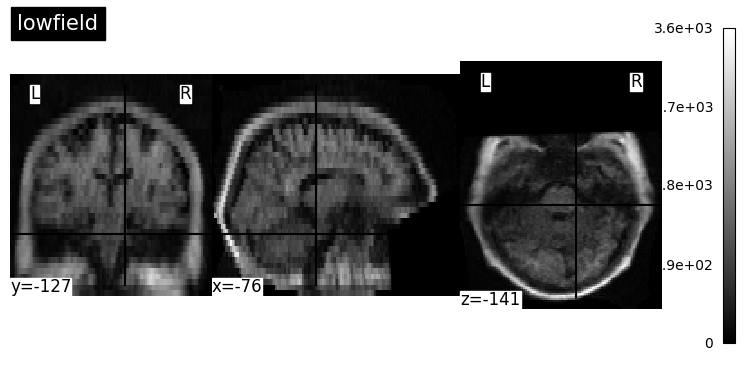

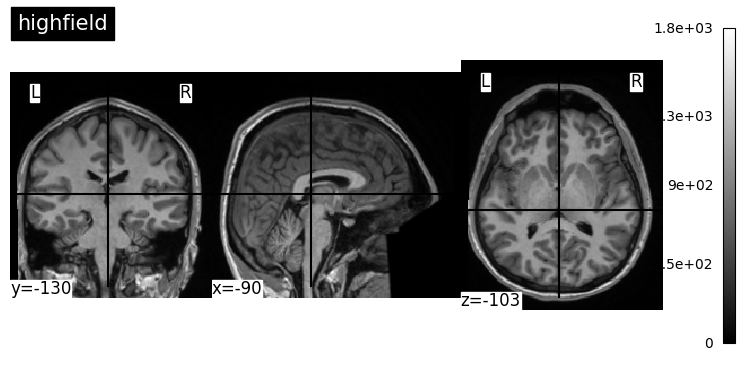

In [9]:
for sample_path in sample_path_pair.items():
    plotting.plot_img(sample_path[1], title=sample_path[0])

### Synthetic Data


In [10]:
def load_synthetic_nifti_pair(sample_id):
    LF_sample_path = os.path.join(
        SYNTHETIC_LF,
        f"08-Apr-2022_Ernst_labels_{sample_id}_3T_T1w_MPR1_img_act_1_contrast_1_Res_1_1_1_img.nii.gz",
    )
    HF_sample_path = os.path.join(
        SYNTHETIC_HF,
        f"08-Apr-2022_Ernst_labels_{sample_id}_3T_T1w_MPR1_img_act_1_contrast_1_Res_0.7_0.7_1_img.nii.gz",
    )

    return {"lowfield": LF_sample_path, "highfield": HF_sample_path}

In [11]:
sample_id = 100206

sample_synthetic_path_pair = load_synthetic_nifti_pair(sample_id)

for sample_path in sample_synthetic_path_pair.items():
    volume = load_nifti(sample_path[1], normalize=True)

    volume = normalize_mri(volume)

    print(volume)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0

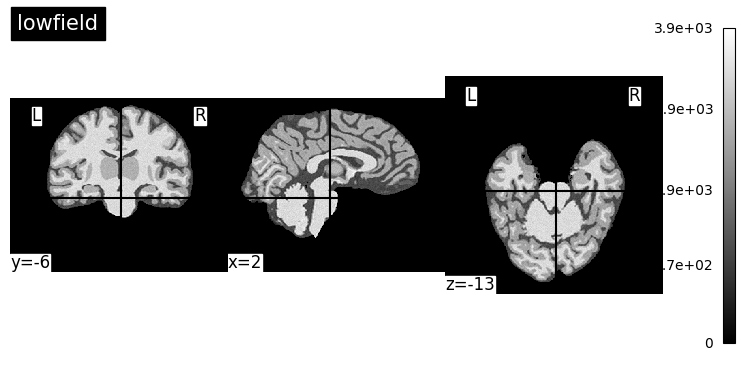

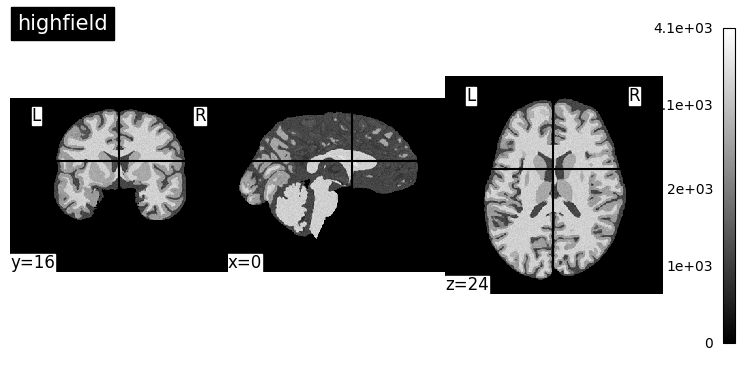

In [12]:
for sample_path in sample_synthetic_path_pair.items():
    plotting.plot_img(sample_path[1], title=sample_path[0])

## Trilinear interpolation


In [13]:
def prepare_input(low_field_path, target_shape=(179, 221, 200)):
    # 1. Load the NIfTI file
    img_nifti = nib.load(low_field_path)
    # print(f"Low-field shape: {img_nifti.shape}")   # Should be (112, 138, 40)
    img_data = img_nifti.get_fdata()
    affine = img_nifti.affine

    # 2. Convert to PyTorch tensor [Batch, Channel, H, W, D]
    tensor = torch.from_numpy(img_data).float().unsqueeze(0).unsqueeze(0)

    # print(f"Tensor Shape: {tensor.shape}")

    # 3. Upsample to match High-Field dimensions
    # 'trilinear' is essential for 3D data to keep it smooth
    upsampled = F.interpolate(
        tensor, size=target_shape, mode="trilinear", align_corners=True
    )

    return upsampled.squeeze(0), affine  # Returns [1, 179, 221, 200] and the affine

In [14]:
def plot_image_trio(path_pair):
    # Test it on one file
    low_path = list(path_pair.items())[0][1]
    high_path = list(path_pair.items())[1][1]

    if os.path.exists(low_path) and os.path.exists(high_path):

        high_nifti = nib.load(high_path)
        target_shape = high_nifti.get_fdata().shape
        print(f"target_shape:{target_shape}")

        processed_tensor, original_affine = prepare_input(low_path, target_shape)

        data_array = processed_tensor.detach().cpu().numpy().squeeze()

        low_shape = nib.load(low_path).shape
        scale_factors = np.array(low_shape) / np.array(data_array.shape)

        new_affine = original_affine.copy()
        new_affine[:3, :3] = original_affine[:3, :3] * scale_factors

        viz_img = nib.Nifti1Image(data_array, new_affine)

        # 1. Plot the Upsampled Image first and capture the display object
        # (We plot this one first or capture it so we can use its coordinates for the others)
        upsampled_display = plotting.plot_img(
            viz_img,
            title="Upsampled Low-Field MRI",
            display_mode="ortho",
            colorbar=True,
        )

        # 2. Extract the automatically selected cut coordinates (x, y, z)
        # These are the world coordinates chosen by nilearn for the upsampled image
        ref_coords = upsampled_display.cut_coords

        # 3. Plot the Target High-Field using the same coordinates
        # We pass 'ref_coords' to cut_coords to force the exact same view
        plotting.plot_img(
            high_nifti,
            title="Target High-Field",
            display_mode="ortho",
            cut_coords=ref_coords,
        )

        # Optional: You can also sync the original low-field to these coordinates
        # for a perfect 3-way comparison:
        plotting.plot_img(
            low_path,
            title="Original Low-Field",
            display_mode="ortho",
            cut_coords=ref_coords,
        )

        plotting.show()


# # Test it on one file
# low_path = list(sample_path_pair.items())[0][1]
# high_path = list(sample_path_pair.items())[1][1]
# # print(low_path)

# if os.path.exists(low_path) and os.path.exists(high_path):

#     high_nifti = nib.load(high_path)

#     target_shape = high_nifti.get_fdata().shape

#     print(f"target_shape:{target_shape}")


#     processed_tensor, original_affine = prepare_input(low_path, target_shape)

#     # print(original_affine)

#     data_array = processed_tensor.detach().cpu().numpy().squeeze()
#     # print(f"New Input Shape: {data_array.shape}")

#     low_shape = nib.load(low_path).shape
#     scale_factors = np.array(low_shape) / np.array(data_array.shape)

#     new_affine = original_affine.copy()
#     new_affine[:3, :3] = original_affine[:3, :3] * scale_factors

#     viz_img = nib.Nifti1Image(data_array, new_affine)

#     plotting.plot_img(low_path, title="Original Low-Field")

#     plotting.plot_img(
#         viz_img, title="Upsampled Low-Field MRI", display_mode="ortho", colorbar=True
#     )

#     # print(f"High-field shape: {high_nifti.shape}")  # Should be (179, 221, 200)

#     # print(high_nifti.shape)

#     plotting.plot_img(high_nifti, title="Target High-Field")

#     plotting.show()

#     # Should output: torch.Size([1, 179, 221, 200])

### Project Data


target_shape:(179, 221, 200)


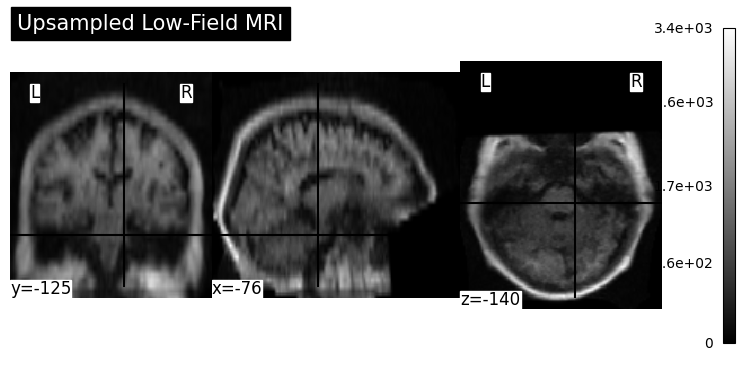

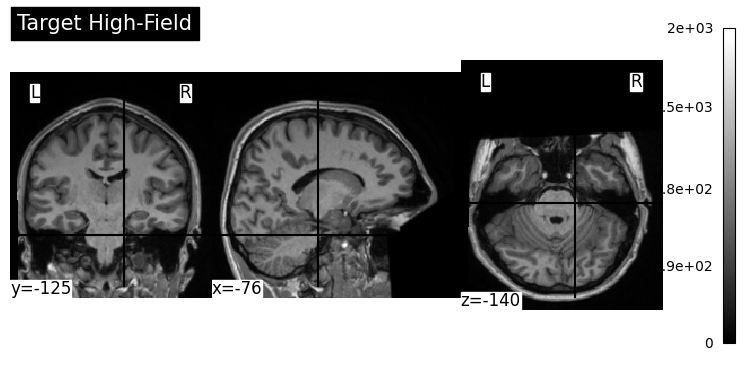

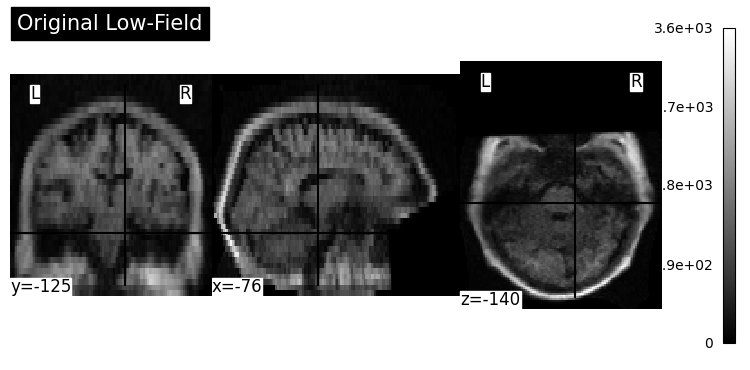

In [15]:
plot_image_trio(sample_path_pair)

### Synthetic Data


target_shape:(320, 320, 179)


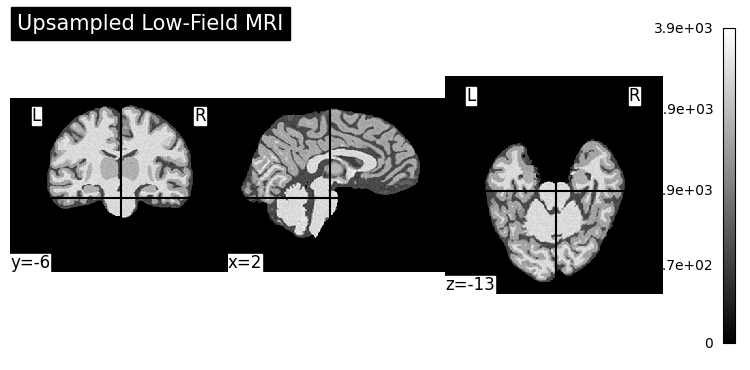

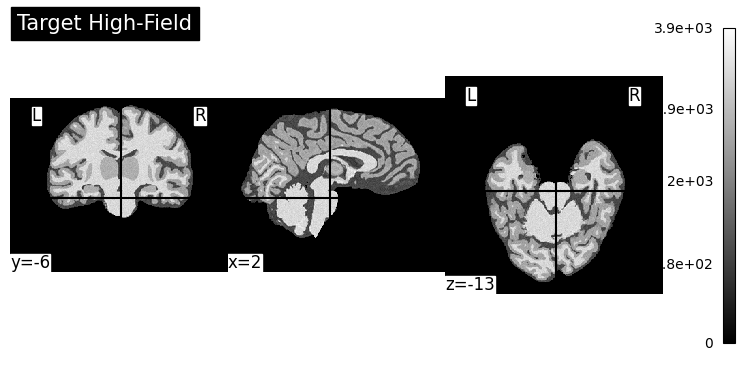

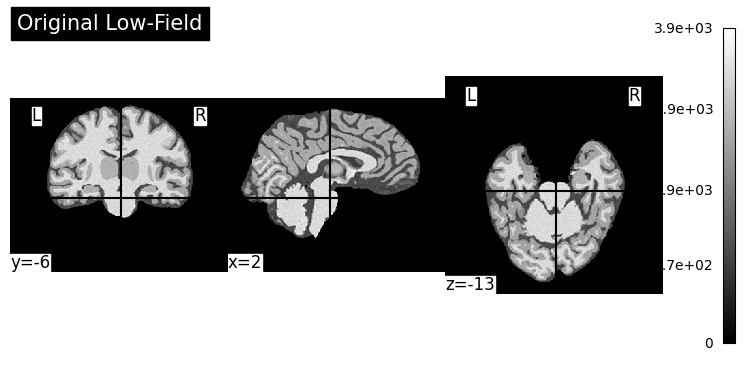

In [16]:
plot_image_trio(sample_synthetic_path_pair)

## Datasets


In [17]:
class MRIPatchDataset(Dataset):
    def __init__(
        self,
        low_paths,
        high_paths,
        patches_per_vol=16,
        patch_size=96,
        transforms=None,
        # target_shape=(179, 221, 200),
    ):
        self.patches_per_vol = patches_per_vol
        self.patch_size = patch_size
        self.transforms = transforms
        self.data = []

        self.target_shape = (1, 1, 1)  # Will overwrite with new target shape

        print(
            "Loading entire dataset into RAM... (This takes ~1 min but speeds up training 50x)"
        )

        for l_path, h_path in zip(low_paths, high_paths):
            # 2. Load High-Field ONCE

            fdata = nib.load(h_path).get_fdata()

            self.target_shape = fdata.shape
            # print(f"target_shape: {target_shape}")

            high_vol = torch.from_numpy(fdata).float().unsqueeze(0)

            # 1. Load and Upsample Low-Field ONCE
            # prepare_input should return tensor (C, D, H, W) or (C, H, W, D)
            low_vol, _ = prepare_input(l_path, target_shape=self.target_shape)

            # 3. Normalize ONCE
            low_vol = normalize_mri(low_vol)
            high_vol = normalize_mri(high_vol)

            # Store in list
            self.data.append({"low": low_vol, "high": high_vol})

    def __len__(self):
        return len(self.data) * self.patches_per_vol

    def __getitem__(self, idx):
        # Map the continuous index to a specific volume
        vol_idx = idx // self.patches_per_vol

        # Retrieve pre-loaded volumes from RAM
        low_vol = self.data[vol_idx]["low"]
        high_vol = self.data[vol_idx]["high"]

        # Get volume dimensions (C, D, H, W)
        # Note: Assuming dims are (1, 179, 221, 200) based on your description
        _, d, h, w = low_vol.shape

        # Ensure patch fits inside volume
        # We subtract patch_size so we don't index out of bounds
        d_start = np.random.randint(0, d - self.patch_size)
        h_start = np.random.randint(0, h - self.patch_size)
        w_start = np.random.randint(0, w - self.patch_size)

        # Extract Patch
        low_patch = low_vol[
            :,
            d_start : d_start + self.patch_size,
            h_start : h_start + self.patch_size,
            w_start : w_start + self.patch_size,
        ]

        high_patch = high_vol[
            :,
            d_start : d_start + self.patch_size,
            h_start : h_start + self.patch_size,
            w_start : w_start + self.patch_size,
        ]

        # Apply MONAI Augmentations (Rotation, Flip, etc.)
        if self.transforms:
            # MONAI usually expects a dict input for MapTransforms
            data_dict = self.transforms({"low": low_patch, "high": high_patch})
            return data_dict["low"], data_dict["high"]

        return low_patch, high_patch

In [18]:
## Uncomment for Project Data
low_field_paths = [os.path.join(LF_TRAIN, p) for p in os.listdir(LF_TRAIN)]
high_field_paths = [os.path.join(HF_TRAIN, p) for p in os.listdir(HF_TRAIN)]

# test_low_field_paths = [os.path.join(LF_TEST, p) for p in os.listdir(LF_TEST)]

## Uncomment for Synthetic Data
# low_field_paths = [os.path.join(SYNTHETIC_LF, p) for p in os.listdir(SYNTHETIC_LF)]
# high_field_paths = [os.path.join(SYNTHETIC_HF, p) for p in os.listdir(SYNTHETIC_HF)]


# print(len(low_field_paths))

cap_size = min(18, len(low_field_paths))

train_size = min(17, cap_size)
val_size = cap_size - train_size


from monai.transforms import (
    Compose,
    RandFlipd,
    RandAffined,
    RandGaussianNoised,
    EnsureTyped,
)

train_transforms = Compose(
    [
        # 1. Randomly flip along any axis (Spatial dims 0, 1, 2)
        RandFlipd(keys=["low", "high"], prob=0.5, spatial_axis=[0, 1, 2]),
        # 2. Slight rotations or scaling (optional, but helps generalization)
        RandAffined(
            keys=["low", "high"],
            prob=0.2,
            rotate_range=(0.1, 0.1, 0.1),
            scale_range=(0.1, 0.1, 0.1),
            mode=("trilinear", "trilinear"),
        ),
        # 3. Add noise ONLY to the input (low-field) to make model robust
        RandGaussianNoised(keys=["low"], prob=0.2, mean=0.0, std=0.01),
        EnsureTyped(keys=["low", "high"]),
    ]
)


train_dataset = MRIPatchDataset(
    low_field_paths[:train_size],
    high_field_paths[:train_size],
    transforms=train_transforms,
)


val_dataset = MRIPatchDataset(
    low_field_paths[train_size : train_size + val_size],
    high_field_paths[train_size : train_size + val_size],
)

# test_dataset = MRITestPatchDataset(test_low_field_paths)

# SEED = 42
# torch.manual_seed(SEED)
# g = torch.Generator().manual_seed(SEED)  # Create a reproducible generator

# # 4. Perform the random split
# train_dataset, val_dataset = random_split(
#     full_dataset, [train_size, val_size], generator=g
# )


# print(train_dataset.low_paths)
# print(train_dataset.high_paths)

# train_dataset.__getitem__(0)
# train_dataset.__getitem__(0)[0].shape

c:\Users\Vince\miniconda3\envs\neuroinfo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading entire dataset into RAM... (This takes ~1 min but speeds up training 50x)
Loading entire dataset into RAM... (This takes ~1 min but speeds up training 50x)


In [19]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    # num_workers=1,
    pin_memory=True,
)

data_loaders = {"train": train_loader, "val": val_loader}

# test_loader = DataLoader(
#     dataset=test_dataset,
#     batch_size=1,
#     shuffle=False,
#     # num_workers=1,
#     pin_memory=True,
# )

# dataloader = DataLoader(
#     dataset=train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     pin_memory=True,
# )

# print(f"Length of full dataset: {len(full_dataset)}")
print(f"Length of training dataset: {len(train_dataset)} patches")
print(f"Length of validation dataset: {len(val_dataset)} patches")
# print(f"Length of test dataset: {len(test_dataset)}")

Length of training dataset: 272 patches
Length of validation dataset: 16 patches


## 3D-UNet


In [20]:
import torch
import torch.nn as nn


class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet3D, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
            )

        # Encoder
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck = conv_block(64, 128)

        # Old Decoder
        # self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        # self.dec2 = conv_block(128, 64)
        # self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        # self.dec1 = conv_block(64, 32)

        # Decoder - Replaced ConvTranspose with Upsample + Conv
        self.up_conv2 = nn.Conv3d(128, 64, kernel_size=1)
        self.dec2 = conv_block(128, 64)

        self.up_conv1 = nn.Conv3d(64, 32, kernel_size=1)
        self.dec1 = conv_block(64, 32)

        self.final = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))

        # Bottleneck
        b = self.bottleneck(self.pool2(e2))

        # # Decoder with skip connections
        # d2 = self.up2(b)
        # # Handle potential padding issues for non-power-of-2 shapes
        # d2 = torch.cat([d2, e2], dim=1)
        # d2 = self.dec2(d2)

        # d1 = self.up1(d2)
        # d1 = torch.cat([d1, e1], dim=1)
        # d1 = self.dec1(d1)

        # Decoder 2: Trilinear Upsampling + 1x1 Conv to adjust channels
        d2 = F.interpolate(b, scale_factor=2, mode="trilinear", align_corners=True)
        d2 = self.up_conv2(d2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        # Decoder 1
        d1 = F.interpolate(d2, scale_factor=2, mode="trilinear", align_corners=True)
        d1 = self.up_conv1(d1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

## Training and Validation Setup


### Metrics and Config


In [21]:
from monai.inferers.utils import sliding_window_inference
from monai.metrics.regression import SSIMMetric, PSNRMetric
from monai.losses.ssim_loss import SSIMLoss

# Initialize metrics
l1_criterion = torch.nn.L1Loss()
ssim_calc = SSIMMetric(spatial_dims=3)
psnr_calc = PSNRMetric(max_val=1.0)

ssim_criterion = SSIMLoss(spatial_dims=3)


# Metrics & Loss
class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.ssim = SSIMLoss(spatial_dims=3, data_range=1.0)

    def forward(self, pred, target):
        return 0.5 * self.l1(pred, target) + 0.5 * self.ssim(pred, target)


ssim_metric = SSIMMetric(spatial_dims=3, data_range=1.0)
psnr_metric = PSNRMetric(max_val=1.0)

### Epoch Training


In [22]:
def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    ssim_metric.reset()
    psnr_metric.reset()
    running_loss = 0.0

    for low, high in tqdm(loader, desc="Train"):
        low, high = low.to(CONFIG["DEVICE"]), high.to(CONFIG["DEVICE"])
        optimizer.zero_grad()

        # with torch.amp.autocast("cuda", enabled=(scaler is not None)):
        with torch.autocast("cuda", enabled=(scaler is not None)):
            output = model(low)
            loss = criterion(output, high)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Update Metrics
        ssim_metric(y_pred=output, y=high)
        psnr_metric(y_pred=output, y=high)
        running_loss += loss.item()

        avg_ssim = ssim_metric.aggregate().item()
        avg_psnr = psnr_metric.aggregate().item()
        avg_loss = running_loss / len(loader)

        combined = (0.5 * avg_ssim) + (0.5 * min(1.0, avg_psnr / 50.0))

    return combined, avg_ssim, avg_psnr, avg_loss

### Epoch Validation


In [23]:
def validate(model, loader, criterion):
    model.eval()
    ssim_metric.reset()
    psnr_metric.reset()
    running_loss = 0.0

    with torch.no_grad():
        for low, high in tqdm(loader, desc="Val"):
            low, high = low.to(CONFIG["DEVICE"]), high.to(CONFIG["DEVICE"])

            # Sliding Window Inference for Full Volume Validation
            output = sliding_window_inference(
                inputs=low,
                roi_size=CONFIG["PATCH_SIZE"],
                sw_batch_size=4,
                predictor=model,
                overlap=0.5,
                mode="gaussian",
            )

            loss = criterion(output, high)
            ssim_metric(y_pred=output, y=high)
            psnr_metric(y_pred=output, y=high)
            running_loss += loss.item()

    avg_ssim = ssim_metric.aggregate().item()
    avg_psnr = psnr_metric.aggregate().item()
    avg_loss = running_loss / len(loader)

    # Leaderboard Formula
    combined = (0.5 * avg_ssim) + (0.5 * min(1.0, avg_psnr / 50.0))

    return combined, avg_ssim, avg_psnr, avg_loss

In [24]:
def train_model(model, loaders, criterion, optimizer, scheduler, num_epochs):
    scaler = torch.amp.GradScaler("cuda") if CONFIG["DEVICE"] == "cuda" else None
    best_score = 0.0
    history = {
        "train_loss": [],
        "train_score": [],
        "train_ssim": [],
        "train_psnr": [],
        "val_loss": [],
        "val_score": [],
        "val_ssim": [],
        "val_psnr": [],
    }

    os.makedirs(CONFIG["PATHS"]["CHECKPOINT"], exist_ok=True)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        t_score, t_ssim, t_psnr, t_loss = train_one_epoch(
            model, loaders["train"], criterion, optimizer, scaler
        )
        print(
            f"Train - Loss: {t_loss:.4f} | SSIM: {t_ssim:.4f} | PSNR: {t_psnr:.4f} | Combined: {t_score:.4f} "
        )

        # Validate
        v_score, v_ssim, v_psnr, v_loss = validate(model, loaders["val"], criterion)
        print(
            f"Val   - Loss: {v_loss:.4f} | SSIM: {v_ssim:.4f} | PSNR: {v_psnr:.4f} | ** Combined: {v_score:.4f} **"
        )

        # Scheduler Step (Maximize Combined Score)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(v_score)
        else:
            scheduler.step()

        # Save History
        history["train_loss"].append(t_loss)
        history["train_score"].append(t_score)
        history["train_ssim"].append(t_ssim)
        history["train_psnr"].append(t_psnr)

        history["val_loss"].append(v_loss)
        history["val_score"].append(v_score)
        history["val_ssim"].append(v_ssim)
        history["val_psnr"].append(v_psnr)

        # Save Best Model
        if v_score > best_score:
            best_score = v_score
            torch.save(
                model.state_dict(),
                os.path.join(CONFIG["PATHS"]["CHECKPOINT"], "best_model.pt"),
            )
            print(">>> New Best Model Saved! <<<")

    return history

## Train Model


### Initialize Model


In [25]:
model = UNet3D().to(CONFIG["DEVICE"])

criterion = HybridLoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=CONFIG["LR"], weight_decay=CONFIG["WEIGHT_DECAY"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)

### Train Model


In [26]:
from wakepy import keep

with keep.running():
    history = train_model(
        model, data_loaders, criterion, optimizer, scheduler, CONFIG["NUM_EPOCHS"]
    )


Epoch 1/100


Train: 100%|██████████| 136/136 [01:17<00:00,  1.76it/s]


Train - Loss: 0.4329 | SSIM: 0.2579 | PSNR: 16.1900 | Combined: 0.2909 


Val:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\Vince\miniconda3\envs\neuroinfo\Lib\site-packages\monai\inferers\utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
c:\Users\Vince\miniconda3\envs\neuroinfo\Lib\site-packages\monai\inferers\utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an err

Val   - Loss: 0.4430 | SSIM: 0.2513 | PSNR: 15.5806 | ** Combined: 0.2815 **
>>> New Best Model Saved! <<<

Epoch 2/100


Train:  88%|████████▊ | 119/136 [01:10<00:10,  1.68it/s]


KeyboardInterrupt: 

### Training Graphs


In [ ]:
plt.figure(figsize=(12, 4))

# --- Subplot 1: Loss ---
plt.subplot(1, 4, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

# --- Subplot 2: SSIM  ---
plt.subplot(1, 4, 2)
plt.plot(history["train_ssim"], label="Train SSIM")
plt.plot(history["val_ssim"], label="Val SSIM")
plt.legend()
plt.title("SSIM")

# --- Subplot 3: PSNR  ---
plt.subplot(1, 4, 3)
plt.plot(history["train_psnr"], label="Train PSNR")
plt.plot(history["val_psnr"], label="Val PSNR")
plt.legend()
plt.title("PSNR")

# --- Subplot 4: Combined Score ---
plt.subplot(1, 4, 4)
plt.plot(history["train_score"], label="Train Score")
plt.plot(history["val_score"], label="Val Score")
plt.legend()
plt.title("Score")

# # --- Subplot 5: Combined ms_ssim ---
# plt.subplot(1, 5, 5)
# plt.plot(history["train_ms_ssim"], label="Train ms_ssim")
# plt.plot(history["val_ms_ssim"], label="Val ms_ssim")
# plt.legend()
# plt.title("ms_ssim")

# plt.tight_layout()


plt.savefig(os.path.join(CONFIG["PATHS"]["CHECKPOINT"], "training_curves.png"))
print(
    f"Train/Val curves saved to {os.path.join(CONFIG['PATHS']['CHECKPOINT'], 'training_curves.png')}"
)

plt.show()

## Testing


In [ ]:
# test_sample_path = os.path.join(LF_TEST, "sample_019_lowfield.nii")

# img = nib.load(test_sample_path)

# data = img.get_fdata()

# display_nifti(data)

In [ ]:
trained_model = UNet3D().to(CONFIG["DEVICE"])

# Join the directory and the filename into one path
checkpoint_path = os.path.join(CONFIG["PATHS"]["CHECKPOINT"], "best_model.pt")


trained_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

In [ ]:
import torch
from tqdm import tqdm
from monai.inferers import sliding_window_inference
import nibabel as nib

test_samples = ["sample_019", "sample_020", "sample_021", "sample_022", "sample_023"]
predictions = {}

trained_model.eval()

with torch.no_grad():
    for sample_id in tqdm(test_samples, desc="Test"):
        # print(f"Processing {sample_id}...")
        low_path = f"test/low_field/{sample_id}_lowfield.nii"

        # 1. Use your Resizer to get the FULL volume [1, 179, 221, 200]
        full_vol, _ = prepare_input(low_path)

        # 2. Normalize and add batch dimension -> [1, 1, 179, 221, 200]
        test_input = normalize_mri(full_vol).to(CONFIG["DEVICE"]).unsqueeze(0)

        # 3. Sliding window handles the patching/stitching AUTOMATICALLY
        output = sliding_window_inference(
            inputs=test_input,
            roi_size=CONFIG["PATCH_SIZE"],
            sw_batch_size=4,
            predictor=trained_model,
            overlap=0.5,
            mode="gaussian",  # This removes the grid lines!
        )

        # 4. Remove extra dimensions to get (179, 221, 200)
        pred_volume = output.squeeze().cpu().numpy()
        # display_nifti(pred_volume)

        # print(f"Final Prediction Shape: {pred_volume.shape}") # Should be (179, 221, 200)
        predictions[sample_id] = pred_volume

# 5. Create Submission File
submission_df = create_submission_df(predictions)
submission_df.to_csv("submission.csv", index=False)
print("Submission saved to submission.csv")

In [ ]:
import matplotlib.pyplot as plt

# 1. Get the first test sample results
sample_id = "sample_021"
pred_volume = predictions[sample_id]  # Shape (179, 221, 200)

# 2. Get the original upsampled input for comparison
low_path = f"test/low_field/{sample_id}_lowfield.nii"
input_tensor, _ = prepare_input(low_path)
input_tensor = normalize_mri(input_tensor)

input_volume = input_tensor.squeeze().cpu().numpy()  # Shape (179, 221, 200)

# 3. Select a middle axial slice (Index 100)
slice_idx = 100

plt.figure(figsize=(12, 6))

# Subplot 1: Input (Bicubic/Trilinear Upsampled)
plt.subplot(1, 2, 1)
plt.imshow(input_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title(f"Upsampled Low-Field (Input)\n{sample_id} - Slice {slice_idx}")
plt.axis("off")

# Subplot 2: Model Prediction (Enhanced)
plt.subplot(1, 2, 2)
plt.imshow(pred_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title(f"Model Enhancement (Prediction)\n{sample_id} - Slice {slice_idx}")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# test_samples = ["sample_019", "sample_020", "sample_021", "sample_022", "sample_023"]
train_samples = ["sample_001", "sample_002", "sample_003"]
predictions = {}

trained_model.eval()

with torch.no_grad():
    for sample_id in tqdm(train_samples, desc="Test"):
        # print(f"Processing {sample_id}...")
        # low_path = f"test/low_field/{sample_id}_lowfield.nii"
        low_path = f"train/low_field/{sample_id}_lowfield.nii"

        # 1. Use your Resizer to get the FULL volume [1, 179, 221, 200]
        full_vol, _ = prepare_input(low_path)

        # 2. Normalize and add batch dimension -> [1, 1, 179, 221, 200]
        test_input = normalize_mri(full_vol).to(CONFIG["DEVICE"]).unsqueeze(0)

        # 3. Sliding window handles the patching/stitching AUTOMATICALLY
        output = sliding_window_inference(
            inputs=test_input,
            roi_size=CONFIG["PATCH_SIZE"],
            sw_batch_size=4,
            predictor=trained_model,
            overlap=0.5,
            mode="gaussian",  # This removes the grid lines!
        )

        # 4. Remove extra dimensions to get (179, 221, 200)
        pred_volume = output.squeeze().cpu().numpy()
        # display_nifti(pred_volume)

        # print(f"Final Prediction Shape: {pred_volume.shape}") # Should be (179, 221, 200)
        predictions[sample_id] = pred_volume


# 1. Get the first test sample results
sample_id = "sample_002"
pred_volume = predictions[sample_id]  # Shape (179, 221, 200)

# 2. Get the original upsampled input for comparison
low_path = f"train/low_field/{sample_id}_lowfield.nii"
high_path = f"train/high_field/{sample_id}_highfield.nii"

high_volume = load_nifti(high_path)

input_tensor, _ = prepare_input(low_path, high_volume.shape)
input_tensor = normalize_mri(input_tensor)

input_volume = input_tensor.squeeze().cpu().numpy()  # Shape (179, 221, 200)

# 3. Select a middle axial slice (Index 100)
slice_idx = 100

plt.figure(figsize=(12, 6))

# Subplot 1: Input (Bicubic/Trilinear Upsampled)
plt.subplot(1, 3, 1)
plt.imshow(input_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title(f"Upsampled Low-Field (Input)\n{sample_id} - Slice {slice_idx}")
plt.axis("off")

# Subplot 2: Model Prediction (Enhanced)
plt.subplot(1, 3, 2)
plt.imshow(pred_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title(f"Model Enhancement (Prediction)\n{sample_id} - Slice {slice_idx}")
plt.axis("off")

# Subplot 3: Model Prediction (Enhanced)
plt.subplot(1, 3, 3)
plt.imshow(high_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title(f"High-Field (Target)\n{sample_id} - Slice {slice_idx}")
plt.axis("off")

plt.tight_layout()
plt.show()